In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
#@hidden_cell

%pylab inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import quandl
import bt


import monthly_returns_heatmap as mrh
figsize(3,3)

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys,os
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage


import pandas as pd
import numpy as np
import scipy
import pprint



In [5]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

In [6]:
storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

In [7]:
swm_info = storage.swarms_info()
pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(swm_info)

In [8]:
product_name = '*'

In [9]:
#instruments_filter = [product_name]  # Select ALL
instruments_filter = ['*']

#exo_filter = ['CL_'] # Select ALL
exo_filter = ['*']

direction_filter = [0, -1, 1] # Select ALL
#direction_filter = [1]

# alpha_filter = ['March_30_2018','EXO']  # Select ALL
alpha_filter = ['May_7','*']
#alpha_filter = ['_AlphaV1Exposure_HedgedBy_V2_Index','Aug','Sept']
#alpha_filter = ['CL_ContFut']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

/var/data/tmqrengine/exobuilder/data/exostorage.py:154: UserWarning: Failed to load new framework alphas: 'equity'
  warnings.warn("Failed to load new framework alphas: {0}".format(exc))


In [10]:
# [print("'{}',".format(s)) for s in sorted(swmdf.columns)];

In [11]:
campaign_exposure = {
'CL_ContFut_Long_EXO' : 1.9,  
'CL_ContFut_Short_EXO': 0.5,  

    
'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_2_Dec_18_custom': 2.0,
'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_Dec_11_custom': 2.0,
'CL_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_1_March_30_2018_custom': 2.0,
    

'CL_ContFut_Short_Strategy_DSP_LPBP_Combination__Bearish_2_March_30_2018_custom': 2.0,
'CL_ContFut_Short_Strategy_DSP_LPBP_Combination__Bearish_2_Dec_19_custom': 2.0,
'CL_ContFut_Short_Strategy_DSP_LowPass__Bearish_Dec_18_custom': 2.0, 

 
    
    
}

In [12]:
campaign_dict = {}
campaign_stats = {'NetProfit': 0.0, 'TradesCount': 0, 'CommissionSum': 0.0}
campaign_deltas_dict = {}

for camp_name, exposure in campaign_exposure.items():
    if camp_name in swmdf:
        swarm_name = camp_name
        campaign_dict[swarm_name] = swmdf[swarm_name] * exposure
        
        # TODO: implement swarm statistics
        for s in swm_data:            
            if s['swarm_name'] != swarm_name:
                continue
            series = s['swarm_series']
            
            
            _delta_arr = campaign_deltas_dict.setdefault('', pd.Series(0, index=series['delta'].index))                                    
            campaign_deltas_dict[''] = pd.concat([_delta_arr, series['delta']*exposure], axis=1).sum(axis=1)
    
campaign_portfolio = pd.DataFrame(campaign_dict).ffill()
campaign_equity = campaign_portfolio.sum(axis=1)
campaign_deltas = pd.DataFrame(campaign_deltas_dict)
print('current Buce CL futures holdings' + str(campaign_deltas.tail(2)))

total = campaign_portfolio.sum(axis=1)
total = pd.DataFrame(total)
total.columns = [ 'Futures_replication'] #change to the campaign
total.index.name = 'date'

print('Estimated Buce CL futures PnL' + str(total.diff().tail(3)  ))
# print(campaign_deltas.abs().max())

Buce_Crude_Oil = total

current Buce CL futures holdings               
2018-09-11  3.4
2018-09-12  3.4
Estimated Buce CL futures PnL            Futures_replication
date                           
2018-09-11              -4802.0
2018-09-12               3932.0
2018-09-13                  0.0


In [13]:
capital = abs(campaign_deltas).max().mul(5).mul(5000)
capital = int(capital)

In [14]:
import bt
import ffn

total = total + capital
total = total.asfreq('D', method='ffill').dropna() 

long_sma  = total.rolling(window=210,center=False).median()

#     # target weights
tw = long_sma.copy()
tw[total > long_sma] = 2.0
tw[total <= long_sma] = 1.00
tw[long_sma.isnull()] = 0.0

    ##here we specify the children (3rd) arguemnt to make sure the strategy
   ## has the proper universe. This is necessary in strategies of strategies
Buy_and_Hold_CL_L = bt.Strategy('Bucephalus Crude Oil Index', 
                                          [bt.algos.WeighTarget(tw),
                                           bt.algos.RunWeekly(),
                                           bt.algos.Rebalance()])




# Buy_and_Hold_ES_L = bt.Strategy('Long CL_L', 
#                       [bt.algos.RunMonthly(),
#                        bt.algos.SelectAll(),
#                        bt.algos.WeighEqually(),
#                        bt.algos.Rebalance()])

# cl_LS_alpha_portfolio = bt.Backtest(Buy_and_Hold_cl_LS, cl_LS)
CL_L_alpha_portfolio = bt.Backtest(Buy_and_Hold_CL_L, total,
#             initial_capital=150000.0, 
            commissions=lambda q, p: max(10, abs(q) * 0.0021),
            integer_positions=True, 
            progress_bar=True)


res_CL_L = bt.run(CL_L_alpha_portfolio)

Bucephalus Crude Oil Index
0% [############################# ] 100% | ETA: 00:00:00

In [15]:
pd.DataFrame(CL_L_alpha_portfolio.security_weights).iloc[-1] 
# pd.DataFrame(campaign_deltas.iloc[-1]) 

Futures_replication    0.943581
Name: 2018-09-13 00:00:00, dtype: float64

In [18]:
try:
    uso_BM = bt.get('uso', start='2012-01-01')

    s_BM = bt.Strategy('Long_Crude_Oil_BM (USO)', [bt.algos.RunMonthly(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    test_BM = bt.Backtest(s_BM, uso_BM)

    r = bt.run(CL_L_alpha_portfolio, test_BM)
except:
    pass

Long_Crude_Oil_BM (USO)
0% [############################# ] 100% | ETA: 00:00:00

In [19]:
data_EW  = res_CL_L.prices

returns = pd.DataFrame(data_EW) 
# .asfreq('BM').tail(1400)
returns.index = pd.to_datetime(returns.index)
returns.columns = ['Bucephalus Crude Oil Index']
# returns = returns.add()

# Bucephalus Crude Oil Index

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


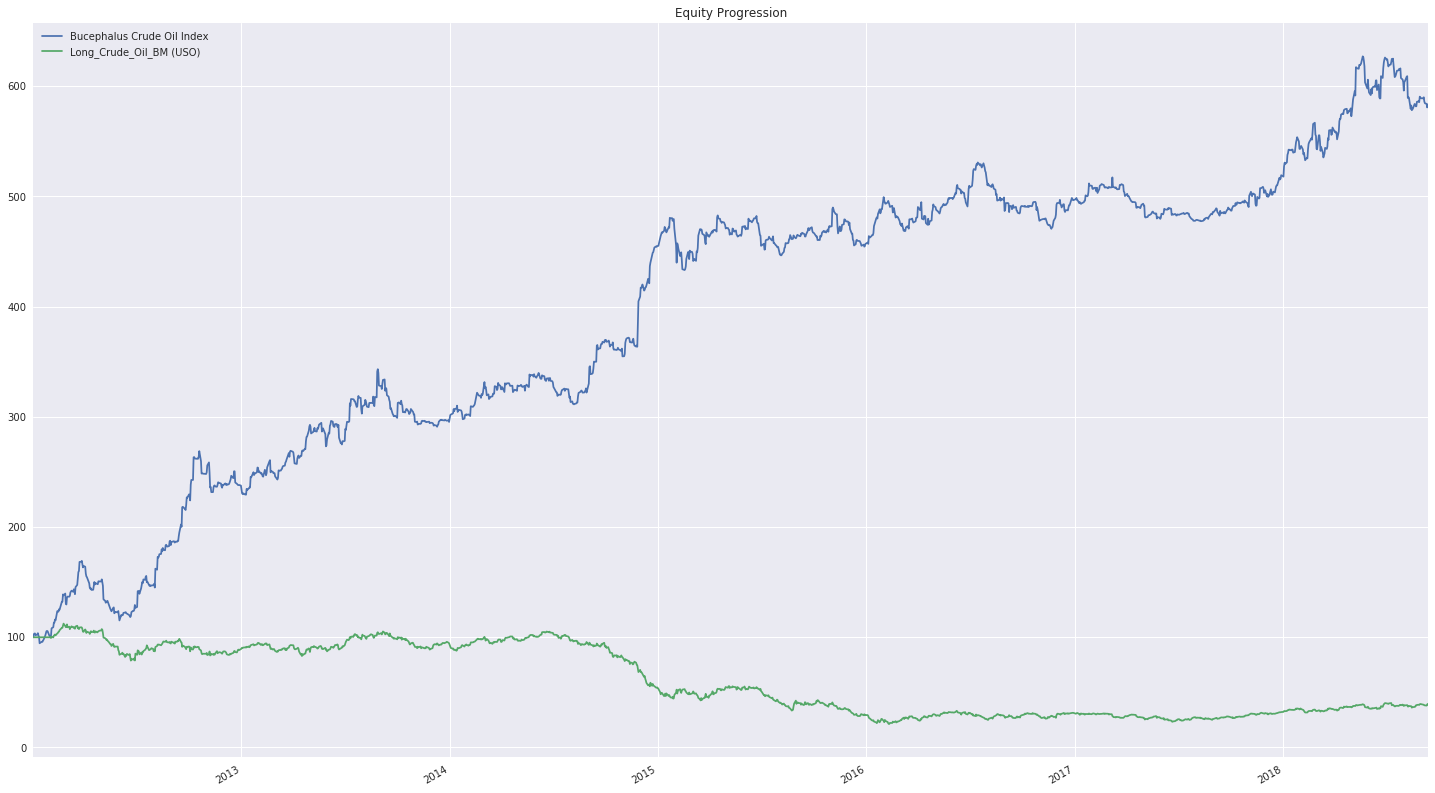

In [21]:
r.plot(figsize=(25, 15))
# r.plot()

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


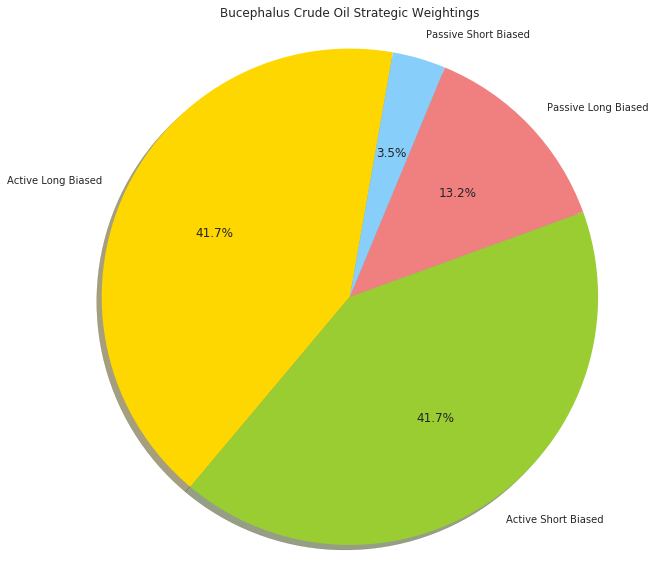

In [22]:
# Data to plot
figsize(10,10)
labels = ['Active Long Biased','Active Short Biased', 'Passive Long Biased', 'Passive Short Biased']
sizes = [6.0, 6.0, 1.9, 0.5]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=80)
 
plt.axis('equal')
plt.title('Bucephalus Crude Oil Strategic Weightings',)
plt.show()

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


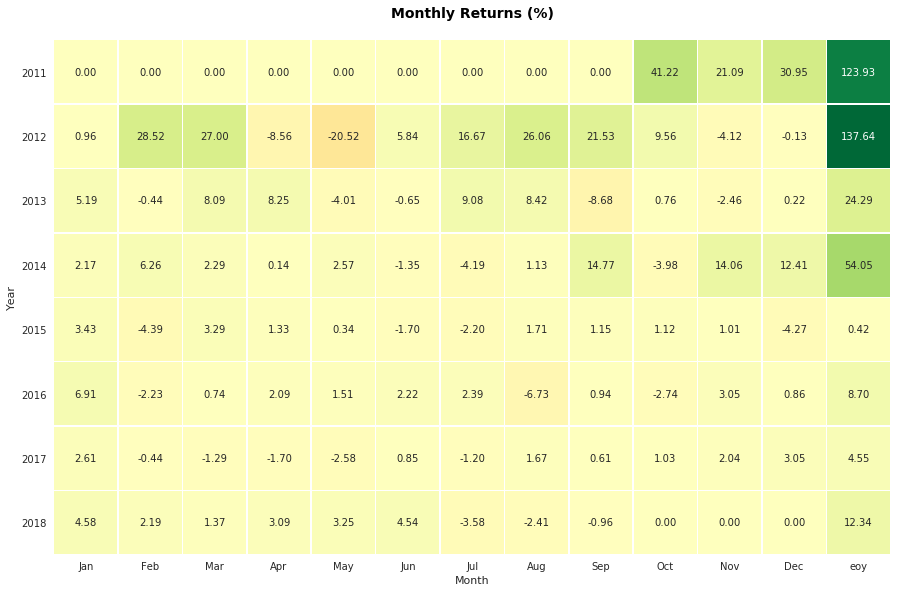

In [23]:
returns.plot_returns_heatmap(is_prices=True,eoy=True,figsize=(15,20),cbar=False, cmap='RdYlGn',square=True)

In [ ]:
r.display()

In [ ]:
r.display_lookback_returns()